# Assignment 3

Spencer Briguglio

103 746 720

## Question #3 Build a three-layer feedforward neural network:
$x → h1 → h2 → o$</br>

The hidden layers h1 and h2 have width 500. Train the network for 250 epochs1 and test the
classification error. Do not use regularizations. Plot the cross-entropy loss on the batches and also plot
the classification error on the validation data.</br>

Comments: 1Each epoch is a pass over the training data. Suppose you use batches of size b, and the
training data set has n points, then an epoch consists of n/b batches. Note that you can divide the data
set into batches, and then round robin over the batches. You can also randomly sample say 64 points
for each batch. Either way is OK, and typically there is no performance difference between them.
When these batches are randomly sampled, it is possible that some point are not in any of them, but
we still call these batches a pass over the data.</br>

Comments: you can also use another dataset, CIFAR-10 or CIFAR-100. Or you can pick your own
dataset.

In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import seaborn as sn
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

# Globals
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
print("[{} enabled]".format(device))

torch.backends.cudnn.enabled = True
torch.manual_seed(0)
generator = torch.Generator().manual_seed(0)

[cuda enabled]


### Loading in the MNIST Data

In [2]:
# Transform function to tell PyTorch to change MNIST image data into normalized tensors
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

# Download Data
testData = torchvision.datasets.MNIST(
    root      = './MNIST',
    train     = False,
    download  = True,
    transform = transform
)

trainData = torchvision.datasets.MNIST(
    root      = './MNIST',
    train     = True,
    download  = True,
    transform = transform
)

train_subset, val_subset = torch.utils.data.random_split(trainData, [0.90, 0.10], generator=generator)

# Split training and validation data

testDataLoader = torch.utils.data.DataLoader(
    dataset     = testData,
    batch_size  = 64,
    shuffle     = True,
    num_workers = os.cpu_count()
)

trainDataLoader = torch.utils.data.DataLoader(
    dataset     = train_subset,
    batch_size  = 64,
    shuffle     = True,
    num_workers = os.cpu_count()
)

valDataLoader = torch.utils.data.DataLoader(
    dataset     = val_subset,
    batch_size  = 64,
    shuffle     = True,
    num_workers = os.cpu_count()
)

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

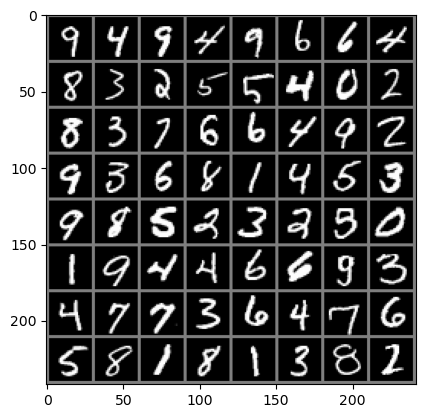

In [3]:
# Display some random training images
data_iter = iter(trainDataLoader)
images, labels = next(data_iter)

# show images
img = torchvision.utils.make_grid(images)

img = img / 2 + 0.5     # unnormalize
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

### Defining The Neural Network

The neural network should have an input-layer, $x$, two hidden layers $h_1$ and $h_2$ and an output layer $o$. Classifying the MNIST images is framed as a multi-class logisitic regression problem which will implement two, fully connected hidden linear layers using the `tanh()` activation function. The output layer will be a softmax layer of width 10 which produces a probability distribution across the 10 classes of digits present in the MNIST data. The class with the highest probability will indicate the predicted class of the sample.

The network has the following architecture:</br>
</br>
$x → h1 → h2 → o$</br>
- $x$ is an input layer of flattened MNIST data of width 784 (28x28px images)
- $h_1$ and $h_2$ are the hidden linear layers, fully-connected, width 500
- $o$ softmax output layer of width 10


#### NOTE
PyTorch's `nn.CrossEntropyLoss` applies softmax at runtime so it must not be included as part of the forward function in `Softmax` class defined below. This has several implications.
1. No need to manually implement a softmax layer.
2. The class labels of the data need NOT be one-hot encoded. This is handled by PyTorch at runtime.
3. The prediction made by the model are raw logits and have not had softmax applied. This is important for making predictions later.

In [4]:
# Define Feed-Forward Neural Network
# NOTE: There is not softmox in the final layer because this is performed
#       automatically at runtime by the nn.CrossEntropyLoss function
class FeedForwardNeuralNetwork(nn.Module):
    def __init__(self):
        super(FeedForwardNeuralNetwork, self).__init__()
        self.h1 = nn.Linear(28 * 28, 500)
        self.tanh = nn.Tanh()
        self.h2 = nn.Linear(500, 10)
        
    def forward(self, x):
        out = self.h1(x)
        out = self.tanh(out)
        out = self.h2(out)
        # Not applying Softmax here!
        return out
        
        
# Initialize the Model
model = FeedForwardNeuralNetwork().to(device)
print(model)

FeedForwardNeuralNetwork(
  (h1): Linear(in_features=784, out_features=500, bias=True)
  (tanh): Tanh()
  (h2): Linear(in_features=500, out_features=10, bias=True)
)


### Training The Neural Network
As defined in the `torch.utils.DataLoaders` instantiated above, the batch size is currently 64. Additionally, the data is randomly shuffled so that the network is exposed to different classes of images in a random distribution. The network will be trained for 250 epochs and the test and training error will be recorded and plotted. Not regularization is used. Both cross-entropy loss and classification error on the validation data will be ploted across training epochs.

In [5]:
# Define Hyperparameters
learning_rate = 0.001
epochs = 200

# Define the loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [6]:
# Define the training function
def train(dataLoader, model, loss_function, optimizer, epochs, val_dataLoader=None):
    print("[Training Initialized]")
    Loss_epoch = []
    Accuracy_epoch = []
    running_loss = 0.0

    for epoch in tqdm(range(epochs), desc="Training [loss: {}]".format(running_loss)):
        n_samples = len(dataLoader.dataset)
        running_loss = 0.0
        model.train()
        Loss_batch = []
        for batch, (X, Y) in enumerate(dataLoader):
            # Load in batch sample and class
            X, Y = X.reshape(-1, 28 * 28).to(device) , Y.to(device)
            # Forward Pass: Output y_pred on sample
            Y_pred = model(X)

            # Get loss
            loss = loss_function(Y_pred, Y)
            Loss_batch.append(loss.item())

            # Backpropagate
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Save Stats
            running_loss +=  loss.item() / (batch+1)

        if val_dataLoader is not None:
            Accuracy_epoch.append(test(val_dataLoader, model, loss_function)) 
        Loss_epoch.append([Loss_batch])
    print("[Training Complete]")
    return Loss_epoch, Accuracy_epoch
                      

# Define the test function
def test(dataLoader, model, loss_function):
    n_samples = 0
    model.eval()
    loss, n_correct = 0, 0
    with torch.no_grad():
        for X, Y in dataLoader:
            X = X.reshape(-1, 28 * 28).to(device)
            Y = Y.to(device)
            raw_out = model(X)
            
            _, Y_pred = torch.max(raw_out, 1)
            n_samples += labels.shape[0]
            n_correct += (Y_pred == Y).sum().item()
            
        accuracy = 100.0 * n_correct / n_samples
        print("Accuracy: {}".format(accuracy), end="\r")
        return accuracy

In [7]:
# Train the model
FFNN_loss, FFNN_acc = train(dataLoader=trainDataLoader, val_dataLoader=valDataLoader, model=model, loss_function=loss_function, optimizer=optimizer, epochs=epochs)

[Training Initialized]


Training [loss: 0.0]:   0%|          | 0/200 [00:00<?, ?it/s]

/home/spencer/anaconda3/envs/DNN/lib/python3.11/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


[Training Complete]76595744


In [8]:
# Saving the model
torch.save(model.state_dict(), "FFNN.save")

In [9]:
# Save Stats
loss_file = open("FFNN_loss.pkl", "wb")
acc_file = open("FFNN_acc.pkl", "wb")

pickle.dump(FFNN_loss, loss_file)
pickle.dump(FFNN_acc, acc_file)

loss_file.close()
acc_file.close()

### Model Evaluation
The model is evaluated against the test set and the confusion matrix shown along with other relavent statistics (F-Score, Recall, etc.). We can see that the model quickly learns the MNIST data very well and exhibits great performance on the both the validation and test data. It should be noted that loss at runtime over the training data was zero which indicates that overfitting is almost certain. However, given the good performance, exhibited across various metrics such a precision, recall and F-score for each label and displayed in the confusion matrix below, we can expect good performance in applied cases.

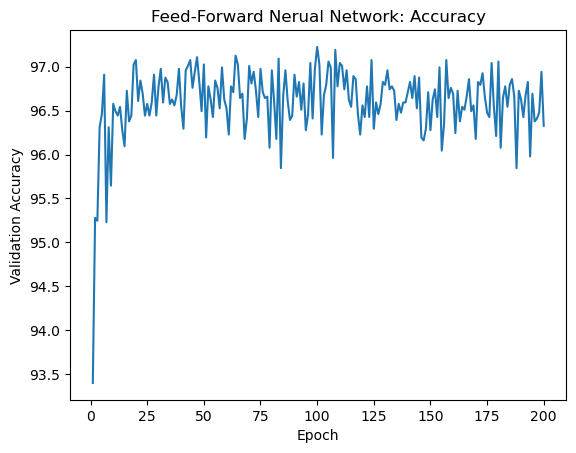

In [10]:
epoch_accuracy = np.asarray(FFNN_acc)
epoch_num = np.linspace(1, epoch_accuracy.shape[0], num=epoch_accuracy.shape[0])

plt.plot(epoch_num, epoch_accuracy)
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Feed-Forward Nerual Network: Accuracy")
plt.show()

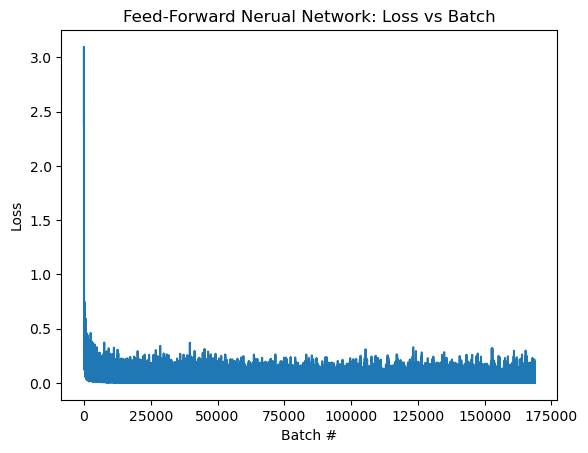

In [11]:
batch_losses = np.asarray(FFNN_loss).flatten()
batch_num = np.linspace(1, batch_losses.shape[0], num=batch_losses.shape[0])

plt.plot(batch_num, batch_losses)
plt.xlabel("Batch #")
plt.ylabel("Loss")
plt.title("Feed-Forward Nerual Network: Loss vs Batch")
plt.show()

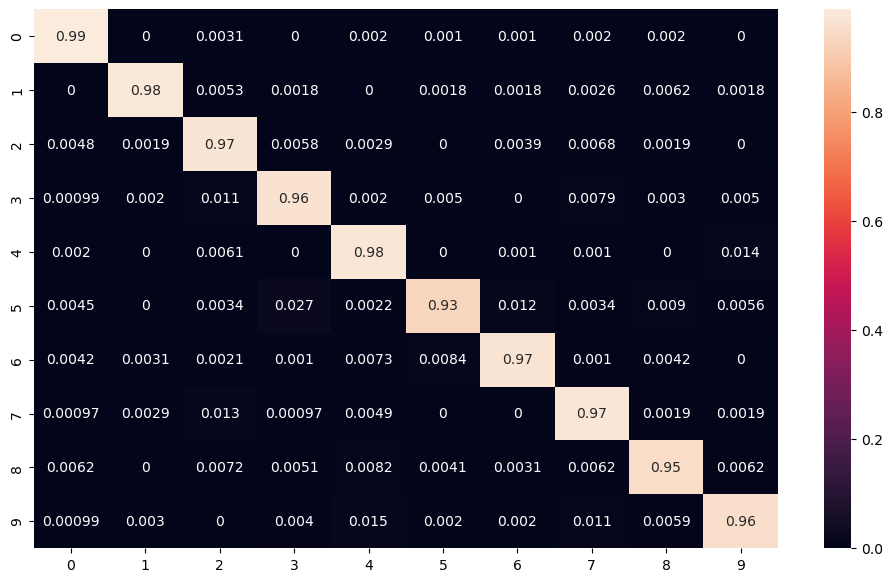

In [12]:
# Evaluate on test data and create confusion matrix
Y_pred = []
Y_true = []

model.eval()

for X, Y in testDataLoader:
    X, Y = X.reshape(-1, 28 * 28).to(device), Y.to(device)
    raw_out = model(X)
    _, out = torch.max(raw_out, 1)
    out = out.cpu().numpy()
    Y_pred.extend(out)
    
    Y = Y.cpu().numpy()
    Y_true.extend(Y)
    
targets = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

cm = confusion_matrix(Y_true, Y_pred)
pd_cm = pd.DataFrame(cm / np.sum(cm, axis=1)[:, None],
                     index = [i for i in targets],
                     columns = [i for i in targets])
plt.figure(figsize=(12,7))
sn.heatmap(pd_cm, annot=True)
plt.savefig('FFNN.png')

In [13]:
prec_FFNN, rec_FFNN, fscore_FNN, _ = precision_recall_fscore_support(Y_true, Y_pred, labels=targets)
print("[Stats] Feed-forward Neural Network\nPrecision: {}\nRecall: {}\nF-Score: {}".format(prec_FFNN, rec_FFNN, fscore_FNN))

[Stats] Feed-forward Neural Network
Precision: [0.97583082 0.98843416 0.9516129  0.95767717 0.95608782 0.97423888
 0.97478992 0.95973154 0.96469367 0.96596597]
Recall: [0.98877551 0.97885463 0.97189922 0.96336634 0.97556008 0.93273543
 0.96868476 0.97373541 0.95379877 0.95639247]
F-Score: [0.98226052 0.98362107 0.96164909 0.96051333 0.96572581 0.95303551
 0.97172775 0.96668276 0.95921528 0.96115538]


/home/spencer/anaconda3/envs/DNN/lib/python3.11/site-packages/numpy/lib/arraysetops.py:729: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


## Question 4
Repeat Question #3 but train the network with the following regularizations: L2-norm, dropout, and early-stopping. Compare with the results of Question #3.

Comments: No need to implement them by your own (this is true in general); the software framework (ie, the DL platform) typically provides implementations for all the regularizations methods discussed in class. Early stopping is done in training, so you only need to tune your training code slightly.

- $L_2$ regularization can be acheived in PyTorch by using weight decay with the ADAM optimizer. 
- Dropout regularization is achieved using `nn.Dropout` after the first hidden layer
- Early Stopping is implemented with a modified `train` function

In [14]:
# Define a model which uses dropout
class FeedForwardNeuralNetwork_Dropout(nn.Module):
    def __init__(self):
        super(FeedForwardNeuralNetwork_Dropout, self).__init__()
        self.h1 = nn.Linear(28 * 28, 500)
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(0.1)
        self.h2 = nn.Linear(500, 10)
        
    def forward(self, x):
        out = self.h1(x)
        out = self.tanh(out)
        out = self.dropout(out)
        out = self.h2(out)
        # Not applying Softmax here!
        return out
        
        
# Initialize the Model
model_Reg = FeedForwardNeuralNetwork_Dropout().to(device)
print(model_Reg)

# Initialize adam optimizer with weight decay for L2 regularization
optimizer_L2 = torch.optim.Adam(model_Reg.parameters(), lr=learning_rate, weight_decay=0.0001)

FeedForwardNeuralNetwork_Dropout(
  (h1): Linear(in_features=784, out_features=500, bias=True)
  (tanh): Tanh()
  (dropout): Dropout(p=0.1, inplace=False)
  (h2): Linear(in_features=500, out_features=10, bias=True)
)


In [15]:
# Define the training function
def train_ES(dataLoader, model, loss_function, optimizer, epochs, patience=3, tolerance=0.05, val_dataLoader=None):
    print("[Training Initialized]")
    Loss_epoch = []
    Accuracy_epoch = []
    running_loss = 0.0
    best_val_accuracy = 0.0
    counter = 0
    for epoch in tqdm(range(epochs), desc="Training [loss: {}]".format(running_loss)):
        n_samples = len(dataLoader.dataset)
        running_loss = 0.0
        Loss_batch = []
        model.train()
        
        for batch, (X, Y) in enumerate(dataLoader):
            # Load in batch sample and class
            X, Y = X.reshape(-1, 28 * 28).to(device) , Y.to(device)
            # Forward Pass: Output y_pred on sample
            Y_pred = model(X)

            # Get loss
            loss = loss_function(Y_pred, Y)
            Loss_batch.append(loss.item())
            running_loss +=  loss.item() / (batch+1)
            
            # Backpropagate
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        Loss_epoch.append([Loss_batch])
        
        if val_dataLoader is not None:
            val_accuracy = test(val_dataLoader, model, loss_function)
            Accuracy_epoch.append(val_accuracy)
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                torch.save(model.state_dict(), "FFNN_reg_CHECKPOINT.save")
                counter = 0
            elif val_accuracy < best_val_accuracy - tolerance:
                ++counter
                if counter > patience:
                    print("[Training Complete (Early Stopping)]")
                    return Loss_epoch, Accuracy_epoch

    print("[Training Complete]")
    return Loss_epoch, Accuracy_epoch

In [16]:
# Train the model
FFNN_Reg_loss, FFNN_Reg_acc = train_ES(dataLoader=trainDataLoader, val_dataLoader=valDataLoader, model=model_Reg, loss_function=loss_function, optimizer=optimizer_L2, epochs=epochs)

# Saving the model
torch.save(model_Reg.state_dict(), "FFNN_reg.save")

Reg_loss_file = open("FFNN_Reg_loss.pkl", "wb")
Reg_acc_file = open("FFNN_Reg_acc.pkl", "wb")

pickle.dump(FFNN_Reg_loss, Reg_loss_file)
pickle.dump(FFNN_Reg_acc, Reg_acc_file)

Reg_loss_file.close()
Reg_acc_file.close()

[Training Initialized]


Training [loss: 0.0]:   0%|          | 0/200 [00:00<?, ?it/s]

/home/spencer/anaconda3/envs/DNN/lib/python3.11/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


[Training Complete]25531915


### Evaluation
This model did not appear to perform as well as other models and this could be due to the need to fine tune the various hyperparameters. Still, the accuracy and recall are very good regardless.

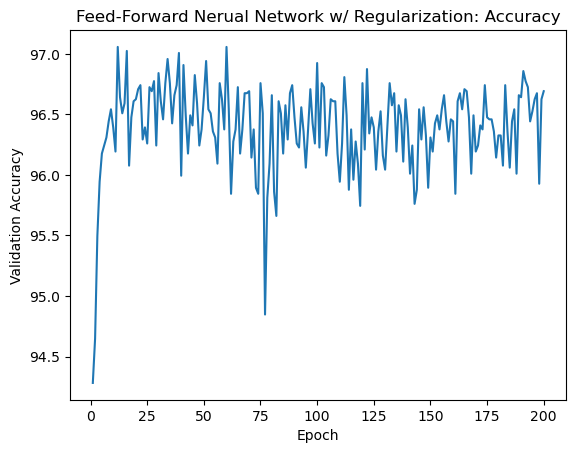

In [17]:
Reg_epoch_accuracy = np.asarray(FFNN_Reg_acc)
Reg_epoch_num = np.linspace(1, Reg_epoch_accuracy.shape[0], num=Reg_epoch_accuracy.shape[0])

plt.plot(Reg_epoch_num, Reg_epoch_accuracy)
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Feed-Forward Nerual Network w/ Regularization: Accuracy")
plt.show()

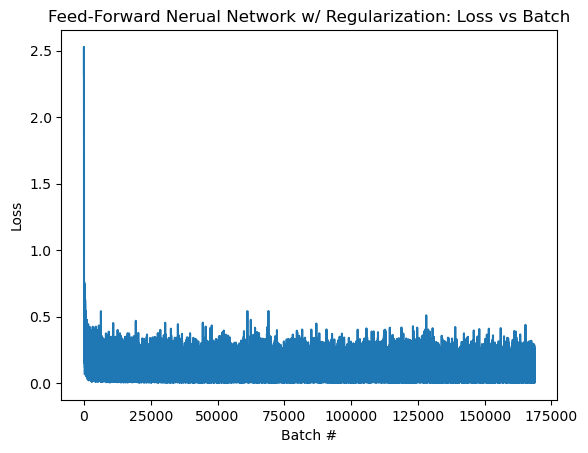

In [18]:
reg_batch_losses = np.asarray(FFNN_Reg_loss).flatten()
reg_batch_num = np.linspace(1, reg_batch_losses.shape[0], num=reg_batch_losses.shape[0])

plt.plot(reg_batch_num, reg_batch_losses)
plt.xlabel("Batch #")
plt.ylabel("Loss")
plt.title("Feed-Forward Nerual Network w/ Regularization: Loss vs Batch")
plt.show()

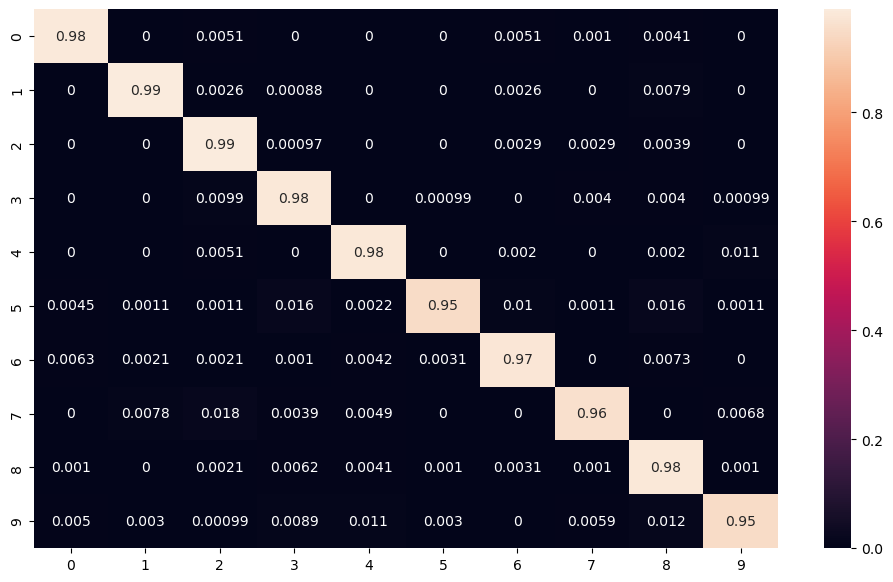

In [19]:
# Load Best Model
model_Reg_BEST = FeedForwardNeuralNetwork_Dropout().to(device)
model_Reg_BEST.load_state_dict(torch.load("FFNN_reg_CHECKPOINT.save"))
model_Reg_BEST.eval()

# Evaluate on test data and create confusion matrix
Y_pred = []
Y_true = []

for X, Y in testDataLoader:
    X, Y = X.reshape(-1, 28 * 28).to(device), Y.to(device)
    raw_out = model_Reg_BEST(X)
    _, out = torch.max(raw_out, 1)
    out = out.cpu().numpy()
    Y_pred.extend(out)
    
    Y = Y.cpu().numpy()
    Y_true.extend(Y)
    
targets = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

cm = confusion_matrix(Y_true, Y_pred)
pd_cm = pd.DataFrame(cm / np.sum(cm, axis=1)[:, None],
                     index = [i for i in targets],
                     columns = [i for i in targets])
plt.figure(figsize=(12,7))
sn.heatmap(pd_cm, annot=True)
plt.savefig('FFNN_Reg.png')

In [20]:
prec_FFNN_Reg, rec_FFNN_Reg, fscore_FNN_Reg, _ = precision_recall_fscore_support(Y_true, Y_pred, labels=targets)
print("[Stats] Feed-forward Neural Network with Regularization\nPrecision: {}\nRecall: {}\nF-Score: {}".format(prec_FFNN_Reg, rec_FFNN_Reg, fscore_FNN_Reg))

[Stats] Feed-forward Neural Network with Regularization
Precision: [0.98369011 0.98764342 0.95599251 0.96491228 0.97368421 0.99062134
 0.97390397 0.98403194 0.9446093  0.97857143]
Recall: [0.98469388 0.98590308 0.98934109 0.98019802 0.9796334  0.94730942
 0.97390397 0.95914397 0.98049281 0.95044599]
F-Score: [0.98419174 0.98677249 0.97238095 0.97249509 0.97664975 0.96848138
 0.97390397 0.97142857 0.96221662 0.96430367]


/home/spencer/anaconda3/envs/DNN/lib/python3.11/site-packages/numpy/lib/arraysetops.py:729: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


## Question 5
Try CNN (convolutional neural networks) on MNIST (or CIFAR or any dataset of your choice). Use the basic minibatch SGD as your learning algorithm, with or without regularizations.

You may need to read Chapter-7, Chapter-8 and Chapter-9

In this implementation we use a CNN with two convolutional layers followed by three fully connected linear layers.

In [21]:
# Define the CNN
# Define a model which uses dropout
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, 1, 2)
        self.pool  = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.1)
        self.conv2 = nn.Conv2d(32, 64, 5, 1, 2)
        self.fc1   = nn.Linear(16 * 7 * 7, 120)
        self.fc2   = nn.Linear(120, 64)
        self.fc3   = nn.Linear(64, 10)
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.pool(out)
        out = self.dropout(out)
        out = F.relu(self.conv2(out))
        out = self.pool(out)
        out = self.dropout(out)
        out = torch.flatten(x, 1)
        out = self.fc1(out)
        out = self.tanh(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.tanh(out)
        out = self.dropout(out)
        out = self.fc3(out)
        # Not applying Softmax here!
        return out
        
        
# Initialize the Model
model_CNN = CNN().to(device)
print(model_CNN)

# Initialize adam optimizer with weight decay for L2 regularization
optimizer_L2_CNN = torch.optim.Adam(model_CNN.parameters(), lr=learning_rate, weight_decay=0.0001)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.1, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (tanh): Tanh()
)


In [22]:
# Define the training function
def train_CNN(dataLoader, model, loss_function, optimizer, epochs, patience=3, tolerance=0.05, val_dataLoader=None):
    print("[Training Initialized]")
    Loss_epoch = []
    Accuracy_epoch = []
    running_loss = 0.0
    best_val_accuracy = 0.0
    counter = 0
    for epoch in tqdm(range(epochs), desc="Training [loss: {}]".format(running_loss)):
        n_samples = len(dataLoader.dataset)
        running_loss = 0.0
        Loss_batch = []
        model.train()
        
        for batch, (X, Y) in enumerate(dataLoader):
            # Load in batch sample and class
            X, Y = X.to(device) , Y.to(device)
            # Forward Pass: Output y_pred on sample
            Y_pred = model(X)

            # Get loss
            loss = loss_function(Y_pred, Y)
            Loss_batch.append(loss.item())
            running_loss +=  loss.item() / (batch+1)
            
            # Backpropagate
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        Loss_epoch.append([Loss_batch])
        
        if val_dataLoader is not None:
            val_accuracy = test_CNN(val_dataLoader, model, loss_function)
            Accuracy_epoch.append(val_accuracy)
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                torch.save(model.state_dict(), "CNN_CHECKPOINT.save")
                counter = 0
            elif val_accuracy < best_val_accuracy - tolerance:
                ++counter
                if counter > patience:
                    print("[Training Complete (Early Stopping)]")
                    return Loss_epoch, Accuracy_epoch

    print("[Training Complete]")
    return Loss_epoch, Accuracy_epoch


# Define the test function
def test_CNN(dataLoader, model, loss_function):
    n_samples = 0
    model.eval()
    loss, n_correct = 0, 0
    with torch.no_grad():
        for X, Y in dataLoader:
            X = X.to(device)
            Y = Y.to(device)
            raw_out = model(X)
            
            _, Y_pred = torch.max(raw_out, 1)
            n_samples += labels.shape[0]
            n_correct += (Y_pred == Y).sum().item()
            
        accuracy = 100.0 * n_correct / n_samples
        print("Accuracy: {}".format(accuracy), end="\r")
        return accuracy

In [23]:
# Train the model
CNN_loss, CNN_acc = train_CNN(dataLoader=trainDataLoader, val_dataLoader=valDataLoader, model=model_CNN, loss_function=loss_function, optimizer=optimizer_L2_CNN, epochs=epochs)

# Saving the model
torch.save(model_CNN.state_dict(), "CNN.save")

CNN_loss_file = open("CNN_loss.pkl", "wb")
CNN_acc_file = open("CNN_acc.pkl", "wb")

pickle.dump(CNN_loss, CNN_loss_file)
pickle.dump(CNN_acc, CNN_acc_file)

CNN_loss_file.close()
CNN_acc_file.close()

[Training Initialized]


Training [loss: 0.0]:   0%|          | 0/200 [00:00<?, ?it/s]

/home/spencer/anaconda3/envs/DNN/lib/python3.11/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


[Training Complete]78723404


### Evaluation
Similarly to the previous question, this model does not perform as well on the validation and test data. I believe this is because of the introduction of more hyperparameters which should be fine-tuines with crossvalidation. In reality, we should expect the CNN to perform the best in the application.

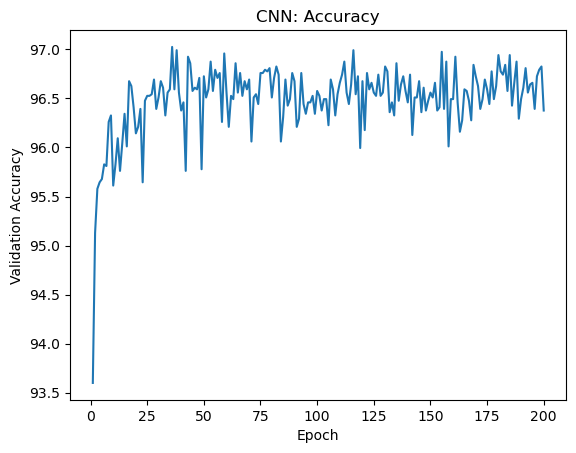

In [24]:
CNN_epoch_accuracy = np.asarray(CNN_acc)
CNN_epoch_num = np.linspace(1, CNN_epoch_accuracy.shape[0], num=CNN_epoch_accuracy.shape[0])

plt.plot(CNN_epoch_num, CNN_epoch_accuracy)
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("CNN: Accuracy")
plt.show()

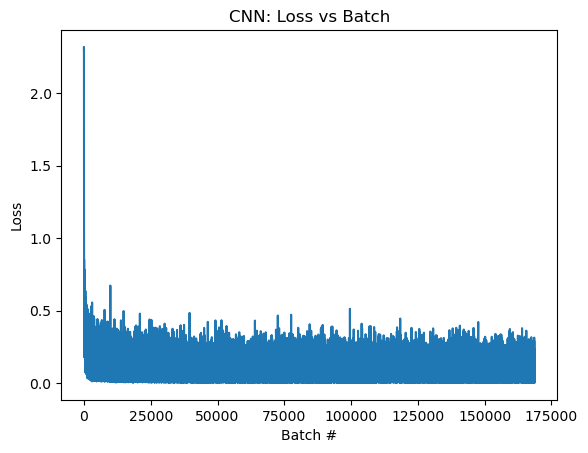

In [25]:
cnn_batch_losses = np.asarray(CNN_loss).flatten()
cnn_batch_num = np.linspace(1, cnn_batch_losses.shape[0], num=cnn_batch_losses.shape[0])

plt.plot(cnn_batch_num, cnn_batch_losses)
plt.xlabel("Batch #")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Batch")
plt.show()

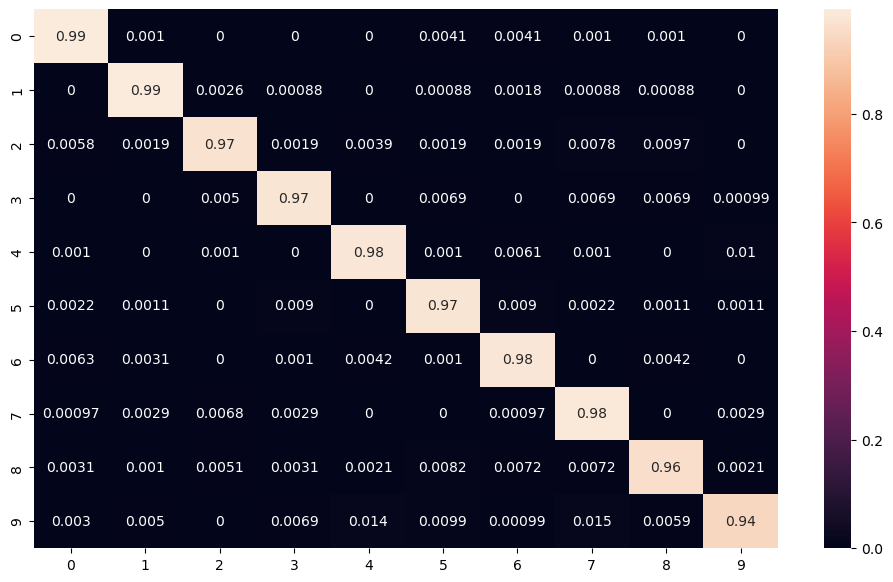

In [26]:
# Load Best Model
model_CNN_BEST = CNN().to(device)
model_CNN_BEST.load_state_dict(torch.load("CNN_CHECKPOINT.save"))
model_CNN_BEST.eval()

# Evaluate on test data and create confusion matrix
Y_pred = []
Y_true = []

for X, Y in testDataLoader:
    X, Y = X.to(device), Y.to(device)
    raw_out = model_CNN_BEST(X)
    _, out = torch.max(raw_out, 1)
    out = out.cpu().numpy()
    Y_pred.extend(out)
    
    Y = Y.cpu().numpy()
    Y_true.extend(Y)
    
targets = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

cm = confusion_matrix(Y_true, Y_pred)
pd_cm = pd.DataFrame(cm / np.sum(cm, axis=1)[:, None],
                     index = [i for i in targets],
                     columns = [i for i in targets])
plt.figure(figsize=(12,7))
sn.heatmap(pd_cm, annot=True)
plt.savefig('CNN.png')

In [27]:
prec_CNN, rec_CNN, fscore_CNN, _ = precision_recall_fscore_support(Y_true, Y_pred, labels=targets)
print("[Stats] Feed-forward Neural Network with Regularization\nPrecision: {}\nRecall: {}\nF-Score: {}".format(prec_CNN, rec_CNN, fscore_CNN))

[Stats] Feed-forward Neural Network with Regularization
Precision: [0.9778002  0.98598949 0.97935103 0.97519841 0.97565923 0.96234773
 0.96804124 0.96007605 0.9689441  0.98238342]
Recall: [0.98877551 0.99207048 0.96511628 0.97326733 0.9796334  0.97421525
 0.98016701 0.98249027 0.96098563 0.9395441 ]
F-Score: [0.98325723 0.98902064 0.97218155 0.97423191 0.97764228 0.96824513
 0.97406639 0.97115385 0.96494845 0.96048632]


/home/spencer/anaconda3/envs/DNN/lib/python3.11/site-packages/numpy/lib/arraysetops.py:729: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
